In [ ]:
import time
import warnings
from collections import defaultdict
from multiprocessing import Process, Queue, queues as qsm

import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

DIR_PATH = "./Datasets"
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (28, 10)

# Data preparation

In [ ]:
df = pd.read_csv(f"{DIR_PATH}/phg_counts.csv").set_index("Unnamed: 0")
mutation_columns = list(df.columns)
df.head()

,T[T>G]T,T[T>C]T,T[T>A]T,G[T>G]T,G[T>C]T,G[T>A]T,C[T>G]T,C[T>C]T,C[T>A]T,A[T>G]T,...,T[C>T]A,T[C>A]C,T[C>G]C,T[C>T]C,T[C>A]G,T[C>G]G,T[C>T]G,T[C>A]T,T[C>G]T,T[C>T]T
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0009b464-b376-4fbc-8a56-da538269a02f,145,130,223,54,114,141,105,129,385,65,...,589,213,147,253,23,29,154,351,545,457
003819bc-c415-4e76-887c-931d60ed39e7,2,4,2,0,1,1,0,0,0,0,...,1,1,1,1,0,0,2,2,0,1
0040b1b6-b07a-4b6e-90ef-133523eaf412,145,160,110,55,169,51,103,261,166,100,...,202,218,81,179,45,11,112,224,200,203
00493087-9d9d-40ca-86d5-936f1b951c93,16,62,18,8,38,8,12,23,6,16,...,35,16,10,52,3,0,61,26,26,55
00508f2b-36bf-44fc-b66b-97e1f3e40bfa,12,31,19,5,32,3,7,17,14,9,...,78,17,17,67,5,1,42,24,37,63


In [ ]:
df_add_info = pd.read_csv(f"{DIR_PATH}/phg_clincal_activities.csv").set_index("Unnamed: 0")
df_add_info = df_add_info[["organ", "tumour_type"]]
df_add_info.head()

,organ,tumour_type
Unnamed: 0,,
0009b464-b376-4fbc-8a56-da538269a02f,Ovary,Recurrent
003819bc-c415-4e76-887c-931d60ed39e7,CNS,Primary
0040b1b6-b07a-4b6e-90ef-133523eaf412,Liver,Primary
00493087-9d9d-40ca-86d5-936f1b951c93,CNS,Primary
00508f2b-36bf-44fc-b66b-97e1f3e40bfa,Pancreas,Primary


In [ ]:
df_add_info_reduced = df_add_info.dropna()
df_add_info_reduced["organ X tumour"] = df_add_info_reduced.apply(lambda x: str(x.organ) + " X " + str(x.tumour_type), axis = 1)
df_add_info_reduced.shape

(6195, 3)

In [ ]:
tumour_counts = df_add_info["tumour_type"].value_counts()
organ_counts = df_add_info["organ"].value_counts()
organ_x_tumour_counts = df_add_info_reduced["organ X tumour"].value_counts()
VALID_TUMORS = list(tumour_counts[tumour_counts > 100].index)
VALID_ORGANS = list(organ_counts[organ_counts > 100].index)
VALID_MIXED = list(organ_x_tumour_counts[organ_x_tumour_counts > 100].index)
print(len(VALID_TUMORS), len(VALID_ORGANS), len(VALID_MIXED))

2 20 18


In [ ]:
# cosmic = pd.read_csv("https://cog.sanger.ac.uk/cosmic-signatures-production/documents/COSMIC_v3.2_SBS_GRCh37.txt", sep='\t', index_col=0)
cosmic = pd.read_csv("./Datasets/cosmic_table.csv", index_col = 0)
cosmic = cosmic.T
cosmic.head()

Type,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,A[C>T]A,A[C>T]C,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
SBS1,8.861572e-04,0.002280,0.000177,0.001280,1.860330e-03,0.001220,0.000115,0.001140,0.025004,0.006321,...,0.000028,0.002250,2.550453e-04,0.003391,0.000416,0.004331,2.230396e-16,0.000055,0.000583,2.230396e-16
SBS2,5.800168e-07,0.000148,0.000052,0.000098,2.230064e-16,0.000133,0.000015,0.000091,0.000061,0.001380,...,0.000050,0.000205,2.230064e-16,0.000044,0.000117,0.000036,1.670048e-05,0.000070,0.000095,2.230064e-16
SBS3,2.080832e-02,0.016507,0.001751,0.012205,1.970788e-02,0.011705,0.000253,0.017407,0.014206,0.012405,...,0.006713,0.013005,1.520608e-02,0.008994,0.006933,0.013906,7.252901e-03,0.006283,0.008053,1.050420e-02
SBS4,4.219650e-02,0.033297,0.015599,0.029498,6.889428e-03,0.002840,0.001280,0.003550,0.008699,0.004180,...,0.009539,0.005620,2.409800e-03,0.000503,0.001740,0.000636,3.769687e-04,0.000174,0.002320,5.679529e-04
SBS5,1.199760e-02,0.009438,0.001850,0.006609,1.009798e-02,0.005699,0.001720,0.010098,0.032593,0.017896,...,0.004789,0.008748,1.799640e-02,0.009708,0.012697,0.018496,5.218956e-03,0.006559,0.006939,1.349730e-02


In [ ]:
# Default - use all data to create distributions
# Organ - partition data by organ type
# Tumour Type - partition data by tumour type
# Organ X Tumour Type - partition data by cartesian product of organ and tumour types

In [ ]:
default_case = dict()
default_case["All"] = df

In [ ]:
organ_case = dict()
for organ_type in VALID_ORGANS:
    idxs = df_add_info[df_add_info["organ"] == organ_type].index
    organ_case[f"X_{organ_type}"] = df.loc[idxs]

In [ ]:
tumour_case = dict()
for tumour_type in VALID_TUMORS:
    idxs = df_add_info[df_add_info["tumour_type"] == tumour_type].index
    tumour_case[f"X_{tumour_type}"] = df.loc[idxs]

In [ ]:
organ_x_tumour_case = dict()
for organ_x_tumour in VALID_MIXED:
    idxs = df_add_info_reduced[df_add_info_reduced['organ X tumour'] == organ_x_tumour].index
    organ_x_tumour_case[f"X_{organ_x_tumour}"] = df.loc[idxs]

In [ ]:
CASES = [("All", default_case), ("Organs", organ_case), ("Tumour", tumour_case), ("Organs x Tumour", organ_x_tumour_case)]

### 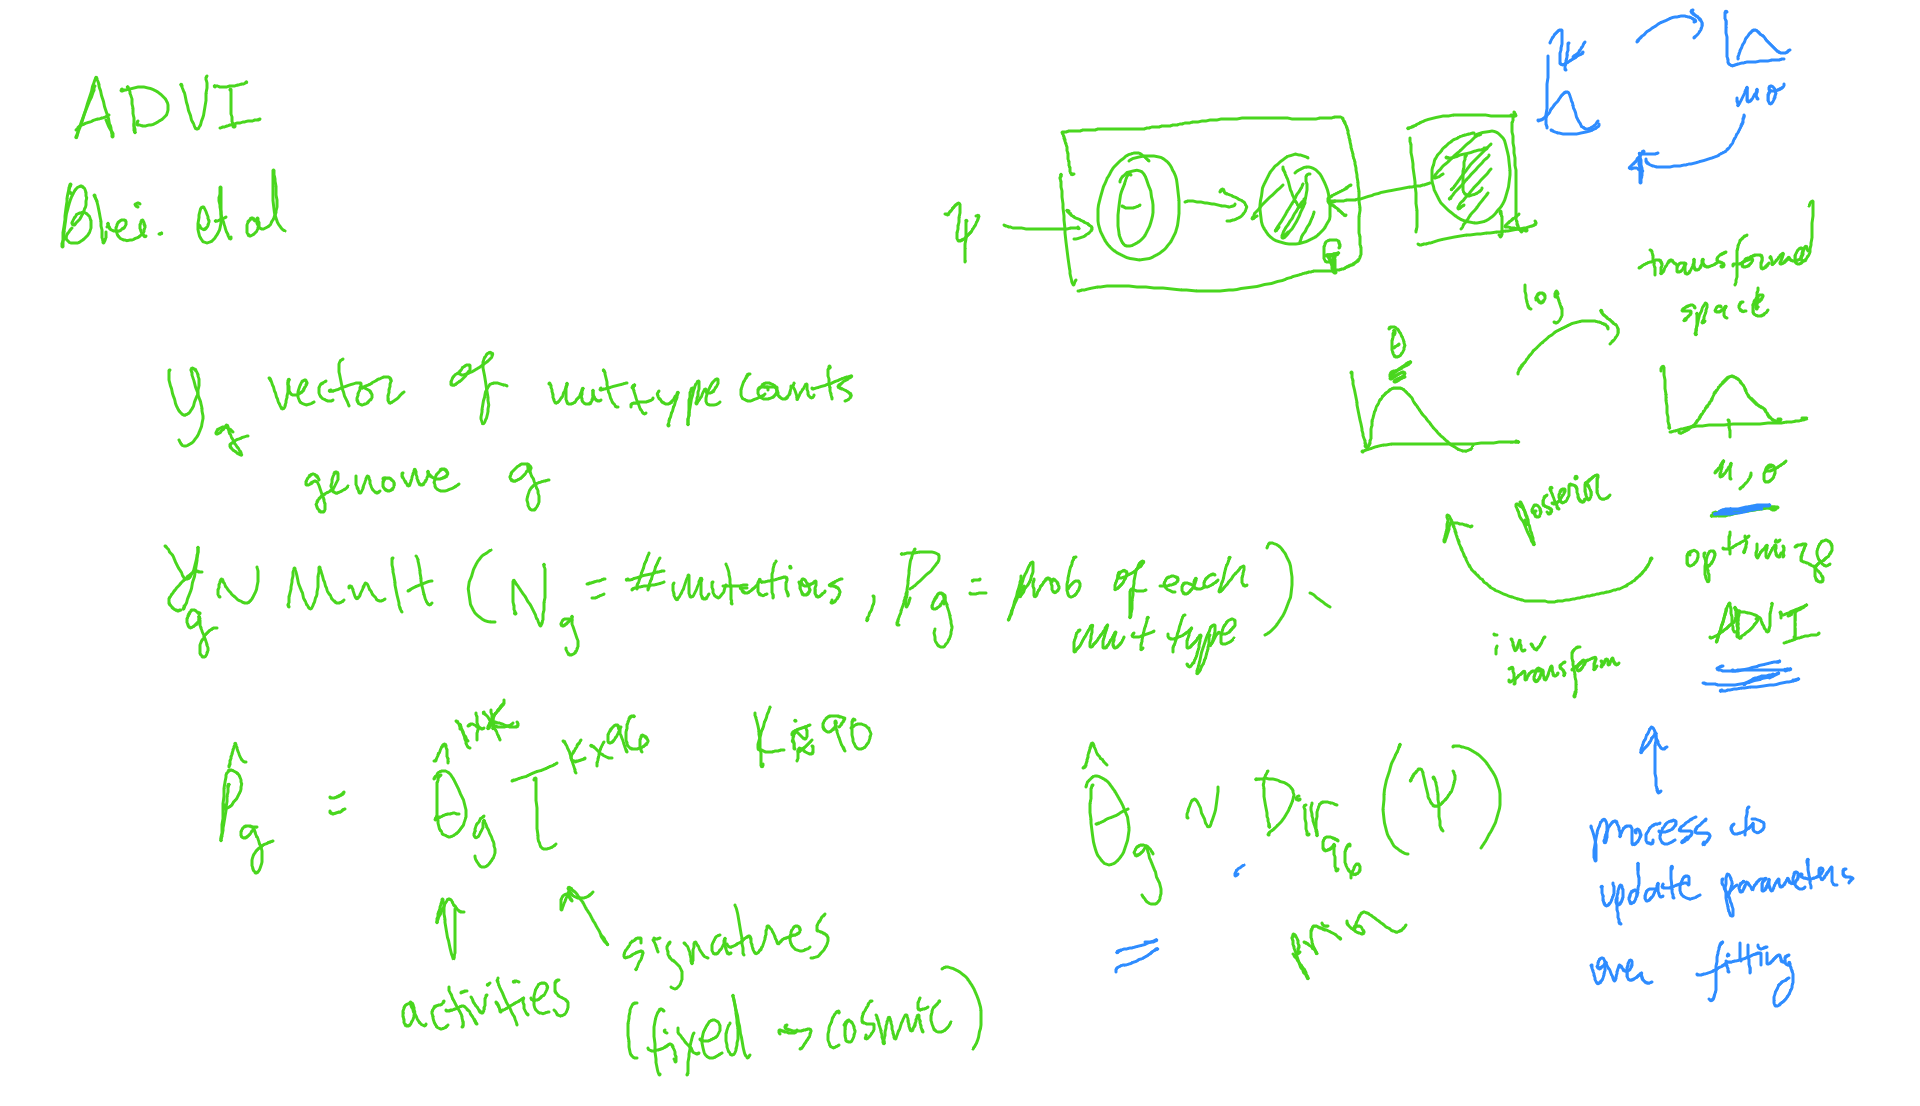

# Modelling

## Model(ADVI)

Here I will use ADVI to optimize ELBO and then sample 15K theta's with optimized parameters

In [ ]:
# N - number of mutations
# K - number of signatures
N = 96
K = 78

In [ ]:
def model(count_df: pd.DataFrame):
    with pm.Model() as dirichlet_model:
        theta = pm.Dirichlet("theta", a = np.ones(K), shape=(K,))
        rho_hat = pm.math.dot(theta, cosmic)
        counts = pm.Multinomial(
            f"counts", n = count_df.sum(axis = 1).values.reshape(-1, 1), p = rho_hat, observed = count_df
        )
        trace = pm.fit(method="advi")
    theta_list = trace.sample(15000)["theta"]
    theta_data = pd.DataFrame(data = theta_list, columns = cosmic.T.columns)
    return theta_data

In [ ]:
procs = []

def run_experiment(case_name, subcase_name, case_data):
    data = model(case_data[subcase_name])
    data.to_csv(f"./Results/ADVI/{case_name}_{subcase_name}.csv")

for case_name, case_data in CASES:
    print(f"General Case - {case_name}")
    for subcase_name in case_data:
        print(f"Model case name - {case_name}")
        proc = Process(target = run_experiment, args = (case_name, subcase_name, case_data))
        procs.append(proc)
        proc.start()
    print()

for proc in procs:
    proc.join()

## Model(MCMC - MetropolisHastings)

In [ ]:
# N - number of mutations
# K - number of signatures
N = 96
K = 78

### Analyzing model

#### Let's start with a model with 10K tune and 15K draws in order to have accurate and representatives estimates with converged chains

In [ ]:
count_df = default_case["All"]
count_df.head()

,T[T>G]T,T[T>C]T,T[T>A]T,G[T>G]T,G[T>C]T,G[T>A]T,C[T>G]T,C[T>C]T,C[T>A]T,A[T>G]T,...,T[C>T]A,T[C>A]C,T[C>G]C,T[C>T]C,T[C>A]G,T[C>G]G,T[C>T]G,T[C>A]T,T[C>G]T,T[C>T]T
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0009b464-b376-4fbc-8a56-da538269a02f,145,130,223,54,114,141,105,129,385,65,...,589,213,147,253,23,29,154,351,545,457
003819bc-c415-4e76-887c-931d60ed39e7,2,4,2,0,1,1,0,0,0,0,...,1,1,1,1,0,0,2,2,0,1
0040b1b6-b07a-4b6e-90ef-133523eaf412,145,160,110,55,169,51,103,261,166,100,...,202,218,81,179,45,11,112,224,200,203
00493087-9d9d-40ca-86d5-936f1b951c93,16,62,18,8,38,8,12,23,6,16,...,35,16,10,52,3,0,61,26,26,55
00508f2b-36bf-44fc-b66b-97e1f3e40bfa,12,31,19,5,32,3,7,17,14,9,...,78,17,17,67,5,1,42,24,37,63


In [ ]:
with pm.Model() as initial_model:
    theta = pm.Dirichlet("theta", a = np.ones(K), shape=(K,))
    rho_hat = pm.math.dot(theta, cosmic)
    counts = pm.Multinomial(
        f"counts", n = count_df.sum(axis = 1).values.reshape(-1, 1), p = rho_hat, observed = count_df
    )
    step = pm.Metropolis()
    trace = pm.sample(draws=15000, tune=20000, step=step, chains=3, return_inferencedata=False, cores=3)

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [theta]


/Users/fedorzhydok/Projects/CSC/venv/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/fedorzhydok/Projects/CSC/venv/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/fedorzhydok/Projects/CSC/venv/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 3 chains for 20_000 tune and 15_000 draw iterations (60_000 + 45_000 draws total) took 290 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
with initial_model:
    pm.plot_autocorr(trace)

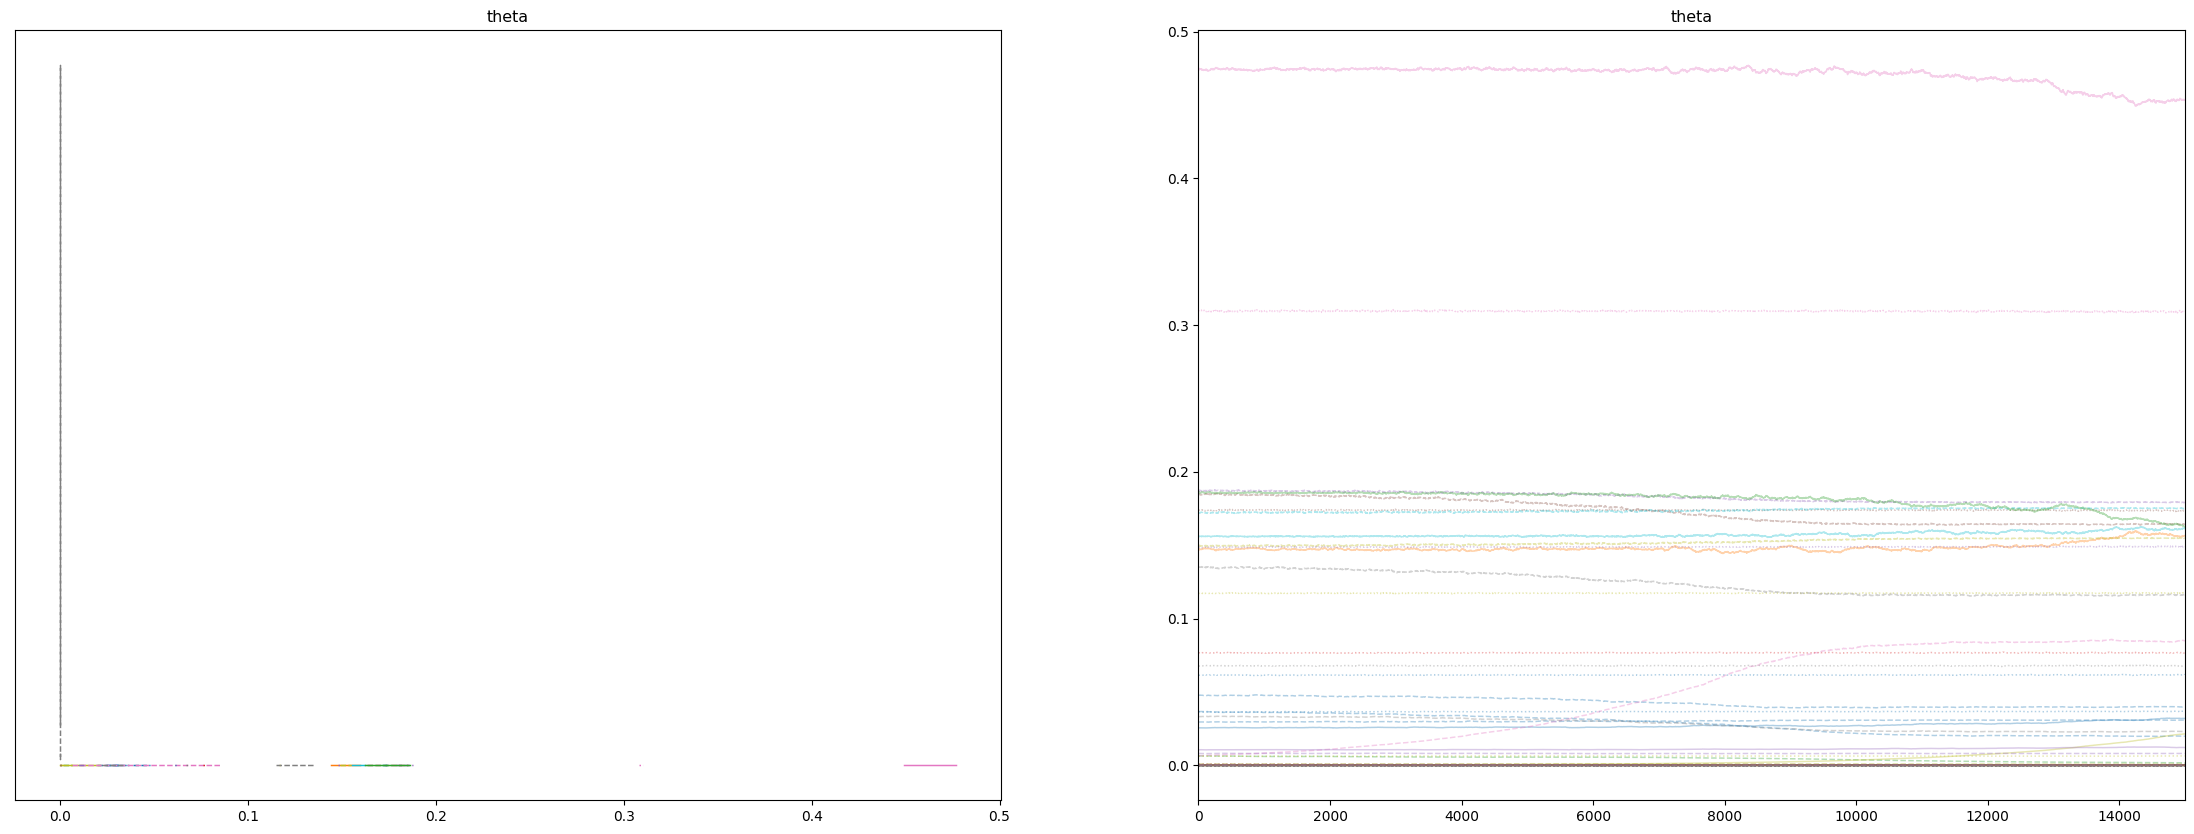

In [ ]:
with initial_model:
    az.plot_trace(data=trace, var_names=["theta"], figsize = (28, 10))

In [ ]:
with initial_model:
    idata = az.from_pymc3(trace)
idata

#### Obviously, as autocorrelation is super high and signatures probabilities are very much concetrated in very narrow regions, we need to increase step width or lower acceptance boundary in order to better explore distribution

##### Model with *σ = 5*

In [ ]:
variance_matrix = np.fill_diagonal(np.zeros((K, K)), 5)

with pm.Model() as more_draws_model:
    theta = pm.Dirichlet("theta", a = np.ones(K), shape=(K,))
    rho_hat = pm.math.dot(theta, cosmic)
    counts = pm.Multinomial(
        f"counts", n = count_df.sum(axis = 1).values.reshape(-1, 1), p = rho_hat, observed = count_df
    )
    step = pm.Metropolis(S = variance_matrix)
    trace = pm.sample(draws=15000, tune=20000, step=step, chains=3, return_inferencedata=False, cores=10)
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["theta"], random_seed=123
    )

In [ ]:
with initial_model:
    pm.plot_autocorr(trace)

In [ ]:
with initial_model:
    az.plot_trace(data=trace, var_names=["theta"], figsize = (28, 10))

In [ ]:
with initial_model:
    idata = az.from_pymc3(trace)
idata

##### Model with *σ = 20*

In [ ]:
variance_matrix = np.fill_diagonal(np.zeros((K, K)), 20)

with pm.Model() as more_draws_model:
    theta = pm.Dirichlet("theta", a = np.ones(K), shape=(K,))
    rho_hat = pm.math.dot(theta, cosmic)
    counts = pm.Multinomial(
        f"counts", n = count_df.sum(axis = 1).values.reshape(-1, 1), p = rho_hat, observed = count_df
    )
    step = pm.Metropolis(S = variance_matrix)
    trace = pm.sample(draws=15000, tune=10000, step=step, chains=3, return_inferencedata=False, cores=10)
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["theta"], random_seed=123
    )

In [ ]:
with initial_model:
    pm.plot_autocorr(trace)

In [ ]:
with initial_model:
    az.plot_trace(data=trace, var_names=["theta"], figsize = (28, 10))

In [ ]:
with initial_model:
    idata = az.from_pymc3(trace)
idata

##### Model with *σ = 50*

In [ ]:
variance_matrix = np.fill_diagonal(np.zeros((K, K)), 50)

with pm.Model() as more_draws_model:
    theta = pm.Dirichlet("theta", a = np.ones(K), shape=(K,))
    rho_hat = pm.math.dot(theta, cosmic)
    counts = pm.Multinomial(
        f"counts", n = count_df.sum(axis = 1).values.reshape(-1, 1), p = rho_hat, observed = count_df
    )
    step = pm.Metropolis(S = variance_matrix)
    trace = pm.sample(draws=15000, tune=10000, step=step, chains=3, return_inferencedata=False, cores=10)
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["theta"], random_seed=123
    )

In [ ]:
with initial_model:
    pm.plot_autocorr(trace)

In [ ]:
with initial_model:
    az.plot_trace(data=trace, var_names=["theta"], figsize = (28, 10))

In [ ]:
with initial_model:
    idata = az.from_pymc3(trace)
idata

### Modelling

In [ ]:
variance_matrix = np.fill_diagonal(np.zeros((K, K)), 5)

def model(count_df: pd.DataFrame):
    with pm.Model() as dirichlet_model:
        theta = pm.Dirichlet("theta", a = np.ones(K), shape=(K,))
        rho_hat = pm.math.dot(theta, cosmic)
        counts = pm.Multinomial(
            f"counts", n = count_df.sum(axis = 1).values.reshape(-1, 1), p = rho_hat, observed = count_df
        )
        step = pm.Metropolis(S = variance_matrix)
        trace = pm.sample(draws=15000, tune=10000, step=step, chains=3, return_inferencedata=False, cores=1)
        ppc = pm.sample_posterior_predictive(
            trace, var_names=["theta"], random_seed=123
        )

    theta_list = ppc["theta"]
    theta_data = pd.DataFrame(data = theta_list, columns = cosmic.T.columns)
    return theta_data

In [ ]:
procs = list()
queue = Queue()

def run_experiment(queue: Queue):
    while True:
        try:
            case_name, subcase_name, case_data = queue.get(timeout=5)
        except qsm.Empty:
            break
        print(f"Case name - {case_name}, subcase name - {subcase_name}")
        data = model(case_data[subcase_name])
        data.to_csv(f"./Results/MetropolisHastings/{case_name}_{subcase_name}.csv")
    print("Done!!!")

for case_name, case_data in CASES:
    for subcase_name in case_data:
        queue.put_nowait((case_name, subcase_name, case_data))

for _ in range(10):
    proc = Process(target = run_experiment, args = (queue,))
    procs.append(proc)
    proc.start()
    time.sleep(2)

for proc in procs:
    proc.join()


## Model(Conjugancy)

#### 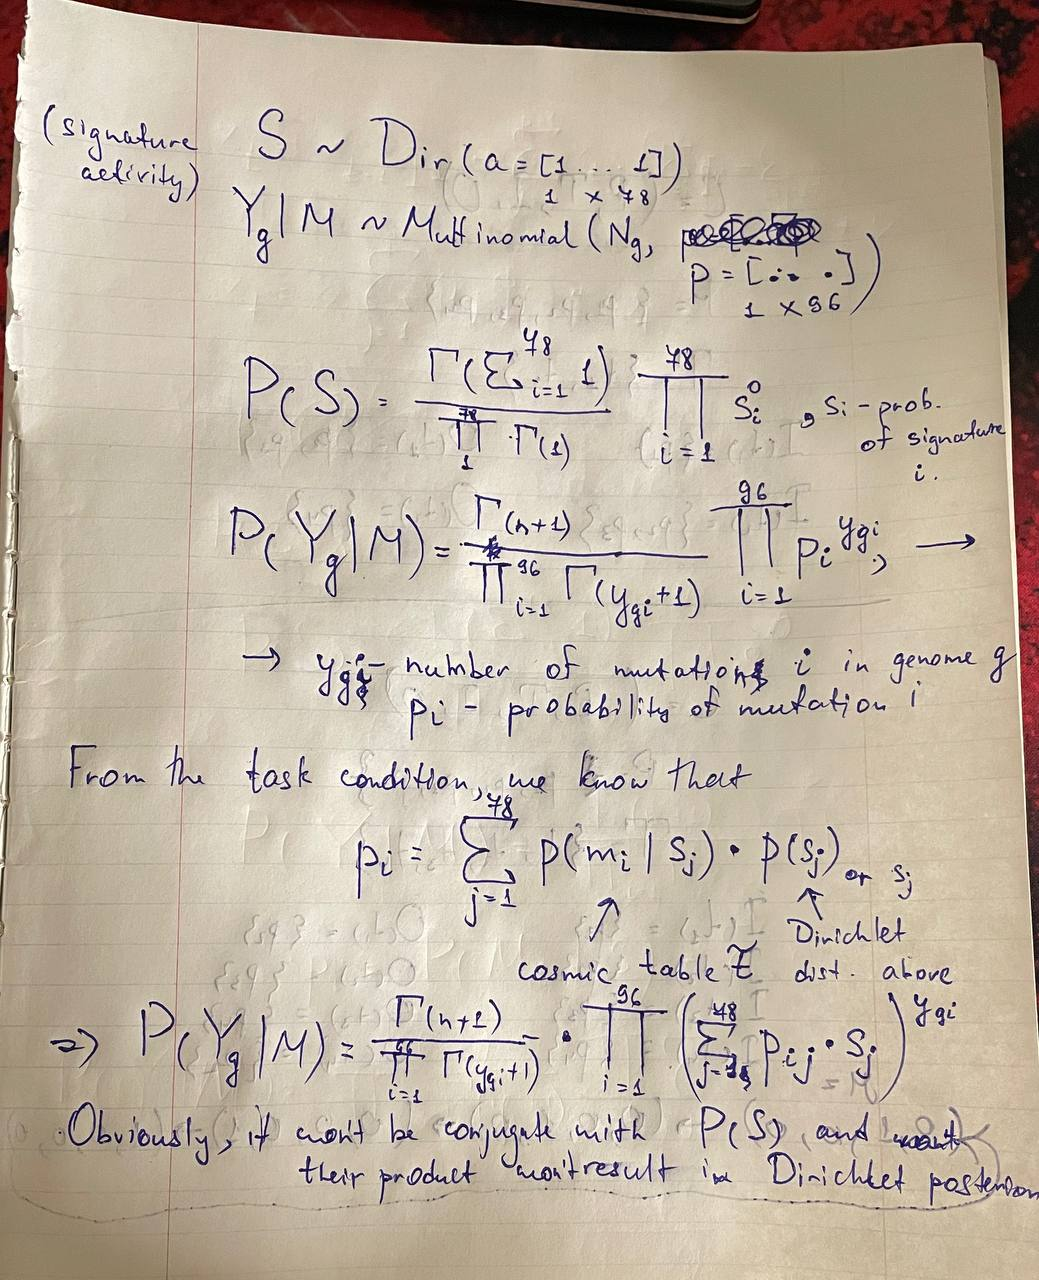